# 5EL272 Systems and algorithms for Autonomous Vehicles
## Exercise 3: Motion Predictions
Created by Junjie Wang & Tomas Nordström, Umeå University

## Revisions:

* 2024-12-13 First version /Junjie
* 2024-12-14 Fixed the tensorflow compatibility issues /Junjie
* 2024-12-15 Cleanup /Tomas
* 2025-12-15 Accelerated Average Displacement Error calculation by a factor of 4, by working in batches. /Tomas
* 2025-12-19 Implemented the possibility to flip y-axis in vis_tracks. /Tomas

##**YOUR NAME**:Rickard Sörlin

## Exercise Goals

In this lab, you will gain hands-on experience in building a Motion Prediction model using the detected trajectories. By completing this exercise, you will:

1. **Understand Motion Prediction Fundamentals**  
   Gain a foundational understanding of Motion Prediction principles, understand the challenge of motion prediction task.

2. **Explore and Implement transformer-based Motion Prediction model**  
   Explore the architecture of transformer-based models and apply them to the motion prediction task.

3. **Explore and build your own Motion Prediction model**  
    Design and train your custom motion prediction model.

For this lab, we will train a  Motion Prediction model on a motion prediction datasets build from V2X-SIM dataset, which contains 1281 samples.

The code (architecture) takes inspiration from the paper: "Girgis, R., Golemo, F., Codevilla, F., Weiss, M., D'Souza, J. A., Kahou, S. E., ... & Pal, C. (2021). Latent variable sequential set transformers for joint multi-agent motion prediction. arXiv preprint [arXiv:2104.00563](https://arxiv.org/abs/2104.00563)."

# Python Setup

In [1]:
#### Set up tests to know if we are running Colab or Kaggle
import sys, os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [2]:
# We will use transformer layers from Keras hub,
# as this will also update tensorflow, we do this before importing tensorflow
if (IS_COLAB or IS_KAGGLE):
    !pip install keras_hub

In [3]:
# setup and import some libraries
import os
# jax backend is not supported for the lab
os.environ["KERAS_BACKEND"] = "torch" # @param ["tensorflow", "torch"]

# Import Keras/TF libraries

import keras
print('Keras version:', keras.__version__)
import keras.ops as ops
from keras import layers
import keras_hub.layers as hub_layers

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import pickle
import numpy as np
import pandas as pd
import zipfile
import gdown
import time

import matplotlib
from matplotlib import pyplot as plt

Keras version: 3.10.0
TensorFlow version: 2.19.0


# Dataset setup

### Dataset description

The dataset consists of 1281 samples, each containing 25 frames of tracked 3D bounding boxes. These frames are sampled at 5Hz, providing a 5-second window for each sample.

#### Task:
Given the first 15 frames (3 seconds) of a sequence, predict the motion of all objects for the next 10 frames (2 seconds).

#### Dataset Fields:

1. **key_frame_points**: The original point cloud data for the 14th frame, primarily for visualization purposes.
2. **key_frame_index**: Indicates the 14th frame as the key frame.
3. **tracks**: A dictionary containing trajectory information for each object:
    * object_id: Unique identifier for the object.
    * boxes: A list of 8 corner points defining the 3D bounding box for each frame.
    * valid: A boolean flag indicating whether the box is padded.


In [ ]:
class MotionDataset(keras.utils.PyDataset):
    # URL to download the motion prediction dataset
    url =  "https://drive.google.com/file/d/1U0luAir0LSP_Esr_HOOaKEFdUi090403/view?usp=share_link"

    def download(self) -> None:
        """
        Download and extract the motion dataset if not already present locally.
        """
        file_name = "lab3_data.zip"
        self.root = './lab3_data'

        if os.path.exists(file_name): # Skip download if file already exists
            return

        # Download the file and extract the contents
        gdown.download(self.url, file_name, fuzzy=True)
        with zipfile.ZipFile(file_name) as archive:
            archive.extractall('./')

    @staticmethod
    def read_lidar(path, nbr_dims = 5):
        """
        Reads LiDAR data from a binary file and reshapes it into points.
        Parameters:
            path (str): Path to the LiDAR binary file.
            nbr_dims (int): Number of dimensions to keep from the point data.
        Returns:
            np.ndarray: The reshaped LiDAR points array.
        """
        scan = np.fromfile(path, dtype='float32')
        points = scan.reshape((-1, 5))[:, :nbr_dims]
        return points

    def __init__(self, n_train_frames=15, max_n_agent=70, batch_size=1, train=True, **kwargs):
        """
        Initializes the dataset.
        Parameters:
            batch_size (int): Number of samples per batch.
            train (bool): Flag to use training or validation split.
            **kwargs: Additional arguments passed to the parent class.
        """
        super().__init__(**kwargs)
        self.download()

        samples = list(sorted(os.listdir(self.root)))
        train_data_split = 0.8
        if train:
            self.samples = samples[: int(len(samples) * train_data_split)]
        else:
            self.samples = samples[int(len(samples) * train_data_split):]

        self.batch_size = batch_size
        self.train = train
        self.max_n_agent = max_n_agent # Used for padding
        self.n_train_frames = n_train_frames # The number of frame used for traning
        self.on_epoch_end()

    def on_epoch_end(self):
        # shuffle
        self.indexes = np.arange(len(self.samples))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """
        Retrieves a batch of samples.
        Parameters:
            index (int): Batch index.
        Returns:

        """
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        positions_b = np.full( (self.batch_size, self.max_n_agent, 25, 2), -1.e-5)
        mask_b = np.full((self.batch_size, self.max_n_agent, 25), 0.)
        
        
        ## Rickard Sörlin AI-assisted copilot and ChatGPT: Added yaw extraction from corners and appened yaw to input tensor ##
         #######################################################################
        yaw_b = np.full((self.batch_size, self.max_n_agent, 25), 0., dtype=np.float32)  # Initialize yaw_b

        for i, index in enumerate(indexes):
            boxes, positions, mask, _, _ = self.fetch_single(index)                                 # Rickard Sörlin changed _ to keep boxes out of the returned values
            n_agent = positions.shape[0]
            positions_b[i, :n_agent] = positions
            mask_b[i, :n_agent] = mask.astype(np.float64)
            vec = boxes[:, :, 1, :2] - boxes[:, :, 0, :2]                                           # Rickard Sörlin added line, yaw computed from box corners 
            yaw = np.arctan2(vec[:, :, 1], vec[:, :, 0])                                            # Rickard Sörlin added line to calculate yaw angle
            yaw_b [i, :n_agent] = yaw                                                               # Rickard Sörlin added line to assign yaw values to yaw_b
            
        sequences = np.concatenate((positions_b, yaw_b[:, :, :, None], mask_b[:, :, :, None]), axis=-1) # Rickard Sörlin added yaw as additional input feature (x,y,yaw,mask)
        #######################################################################


        x = sequences[:, :, :self.n_train_frames] # the first n frames is used for training.
        y = sequences[:, :, self.n_train_frames:] 
        y = y[:, :, :, [0,1,3]]                                                                     #  Rickard Sörlin changed keep targets as x,y, mask only 
        y[:, :, :, :2] = y[:, :, :, :2] - x[:, :, -1:, :2] # relative location
        
        return x, y

    def fetch_single(self, idx):
        """
        Fetches and processes a single sample.
        Parameters:
            idx (int): Sample index.
        Returns:
            tuple:
                - boxes_np (ndarray): 8 corner bounding boxes (shape: n_agent, T, 8, 3).
                - positions_np (ndarray): the xy center of bounding boxes (shape: n_agent, T, 2).
                - mask_np (ndarray): valid mask that indicate whether a box is valid. (shape: n_agent,T)
                - key_frame_points (ndarray): LiDAR points (shape:n_points, 5).
                - key_frame_index int: the index of key frame.
        """
        sample_path = os.path.join(self.root, self.samples[idx])

        with open(sample_path, 'rb') as f:
            sample = pickle.load(f)

        key_frame_points = sample['key_frame_points'] # only used for visualization
        tracks = sample['tracks']
        key_frame_index = sample['key_frame_index']

        boxes_l = []
        positions_l = []
        mask_l = []

        for object_id in tracks:
            boxes = tracks[object_id]['boxes']
            positions = boxes[:, :, :2].mean(axis=1, keepdims=False)
            boxes_l.append(boxes[None])
            positions_l.append(positions[None])
            mask_l.append(tracks[object_id]['valid'][None])

        boxes_np = np.concatenate(boxes_l, axis=0)  # n_agent, T, 8, 3
        positions_np = np.concatenate(positions_l, axis=0) # n_agent, T, 2
        mask_np = np.concatenate(mask_l, axis=0) # n_agent, T
        return boxes_np, positions_np, mask_np, key_frame_points, key_frame_index

    def no_data_elements(self):
        """
        Return the total number of samples.
        """
        return len(self.samples)

    def __len__(self):
        """
        Returns the total number of batches.
        """
        return len(self.samples) // self.batch_size

In [5]:
def vis_tracks(points, boxes=None, tracks=None, maskes=None, ax=None, figsize=(10, 10), color_b='r', color_t=None, flip_y=True):
    """Visualizes tracks.
    Args:
        points: ndarray of shape (N, 2)  the key frame point cloud data.
        boxes: ndarray of shape (n_agent, 4, 2) the key frame bounding boxes.
        tracks: ndarray of shape (n_agent, T, 2) the xy center trajectories.
        masks: ndarray of shape (K, T) representing track masks.
        ax: An optional Matplotlib Axes object to plot on.
        figsize: A tuple specifying the figure size.
        color_b: The color for bounding boxes.
        color_t: The color for tracks.
        flip_y: Boolean, if True, flips the y-axis coordinates.
    Returns:
        The Matplotlib Axes object used for plotting.
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    if flip_y:
        points_flipped = np.copy(points)
        points_flipped[:, 1] = -points_flipped[:, 1]
        ax.scatter(points_flipped[:, 0], points_flipped[:, 1], s=1)
    else:
        ax.scatter(points[:, 0], points[:, 1], s=1)

    if boxes is not None:
        show_bboxes(ax, boxes, color_b, flip_y=flip_y)

    if tracks is not None:
        show_tracks(ax, tracks, maskes, color_t, flip_y=flip_y)
    return ax

def show_bboxes(axes, bboxes, color=None, flip_y=True):
    bboxes_2d = bboxes[:,:4,:2]
    if flip_y:
        bboxes_2d = np.copy(bboxes_2d)
        bboxes_2d[:, :, 1] = -bboxes_2d[:, :, 1]
    for bbox in bboxes_2d:
        rect = plt.Polygon(xy=bbox, fill=False, color=color)
        # Add the rectangle to the axes
        axes.add_patch(rect)

def show_tracks(axes, tracks, maskes=None, color=None, flip_y=True):
    for track, mask in zip(tracks, maskes):
        track_to_plot = track[mask]
        if flip_y:
            track_to_plot = np.copy(track_to_plot)
            track_to_plot[:, 1] = -track_to_plot[:, 1]
        if track_to_plot.shape[0] == 0:
            continue
        axes.plot(track_to_plot[:, 0], track_to_plot[:, 1], '.-', color=color, linewidth=1)

## Visualize a sample data to see what the dataset looks like.

Downloading...
From (original): https://drive.google.com/uc?id=1U0luAir0LSP_Esr_HOOaKEFdUi090403
From (redirected): https://drive.google.com/uc?id=1U0luAir0LSP_Esr_HOOaKEFdUi090403&confirm=t&uuid=05d657a8-e590-48fb-abf6-8c171190b7c0
To: /content/lab3_data.zip
100%|██████████| 557M/557M [00:13<00:00, 41.5MB/s] 


<Axes: >

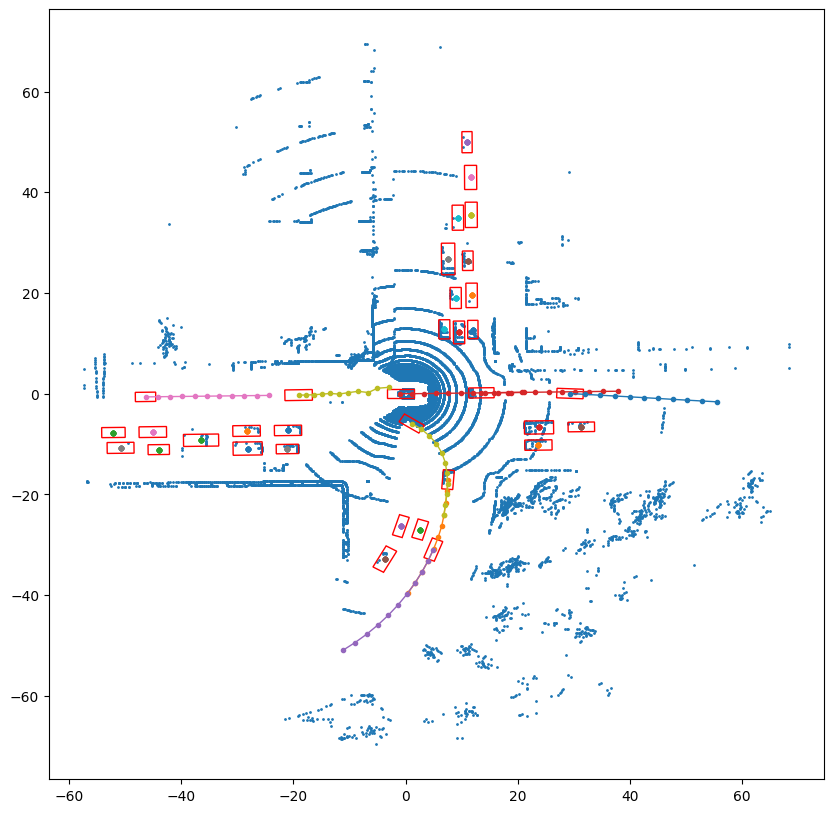

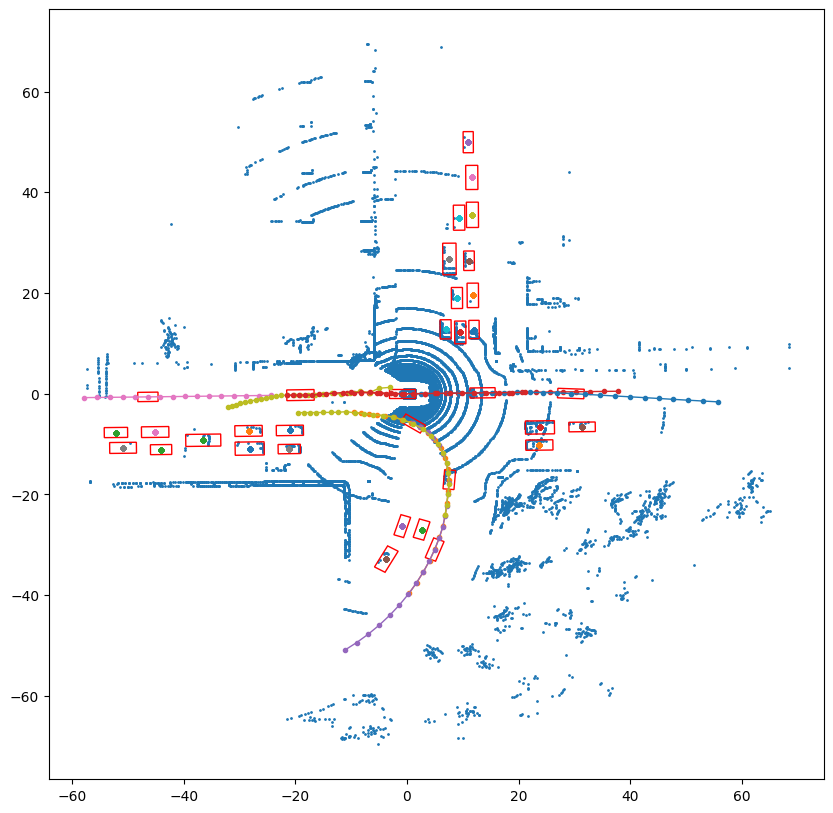

In [6]:
dataset = MotionDataset()
boxes, positions, mask, key_frame_points, keyframe_index = dataset.fetch_single(10)

# visualize the future trajectories
vis_tracks(key_frame_points, boxes[:, keyframe_index], positions[:, keyframe_index:], mask[:, keyframe_index:])
# comment out this to visualize both the past and the future trajectories
#
vis_tracks(key_frame_points, boxes[:, keyframe_index], positions, mask)

# Past and the future trajectories
###

# Build a Motion Prediction Model

## Overall structure

The goal is to build a mode that provides motion preditions based on the input agent (vehicle) trajectories.

This can be done in many ways, but here we will leverage the Transformer architecture that allows us to effectively capture both complex temporal and spatial dependencies between agents.


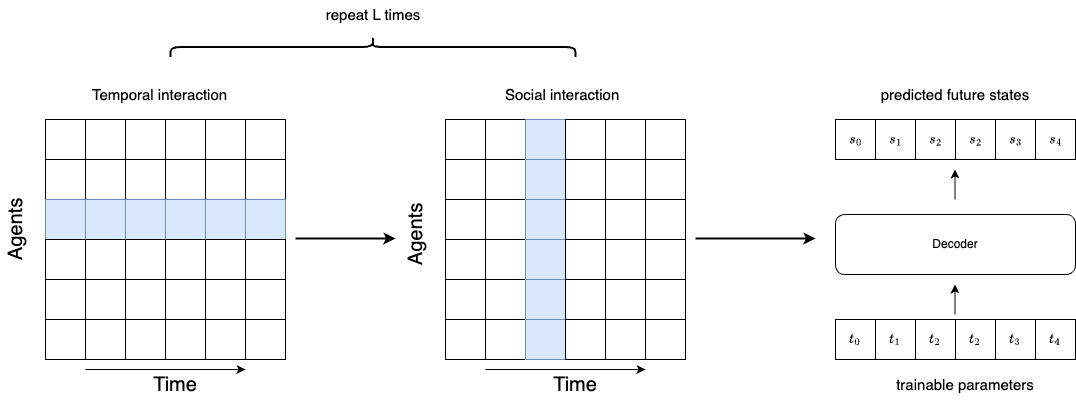


Key Components and Functionality:

* Temporal Encoder:
    Processes each agent's trajectory independently using a Transformer encoder.
    Captures temporal dependencies within each agent's motion history.

* Social Layer:
    Encodes interactions between agents by treating them as a sequence of agents at each time step.
    Captures spatial dependencies between agents.

* Temporal Decoder:
    Generates future trajectories for each agent, conditioned on the encoded past trajectories and social interactions.
    Utilizes a Transformer decoder to sequentially predict future positions.

To implement these transformer layers we will use the ones implemented in Keras:
* [keras_hub.layers.TransformerEncoder](https://keras.io/keras_hub/api/modeling_layers/transformer_encoder/)
* [keras_hub.layers.TransformerDecoder](https://keras.io/keras_hub/api/modeling_layers/transformer_decoder/)

These layer definitions follows the architecture of the transformer layers in the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) that first introduced the Transformer architecture.


### Model Training

The model is trained with a mean absolute error (MAE) loss function that undersamples stationary agents to balance the dataset. The model's performance is evaluated using the Average Displacement Error, measuring the average Euclidean distance between predicted and ground truth trajectory points.

### Details of the Model

Let's break down the Transformer model in greater detail, focusing on input/output shapes, embedding sizes, and how temporal sequences are handled.

**1. Input Shape**

*   The model takes as input a tensor of shape (B, n_agent, T, 3).
    *   B: Batch size (number of samples processed simultaneously)
    *   n_agent: Maximum number of agents (70 in this case, padded if fewer)
    *   T: Length of the past time step sequence (15 frames in this case)
    *   3: (x, y, mask) where x and y are coordinates, and mask is a binary value indicating if the agent is valid or padded.

**2. Temporal Encoding**

*   Each agent's trajectory (x, y coordinates over time) is treated as a sequence.
*   This sequence is fed into the `TemporalEncoder` layer.
*   Inside `TemporalEncoder`, a `keras_hub.layers.TransformerEncoder` is used.
We use a "SinePositionEncoding" as a positional encoding to capture the order of the temporal sequence

**3. Social Layer**

*   The output of the temporal encoding step is passed to the `SocialLayer`.
*   The `SocialLayer` uses another `keras_hub.layers.TransformerEncoder` to capture interactions between all agents at each time step.
*   This layer helps the model understand the spatial relationships between different agents in the scene.

We repeat the Temporal Encoding Layer and Social Layer an additional time.

**4. Temporal Decoder**

*   The `TemporalDecoder` layer takes the output of the `SocialLayer` and generates future trajectories for each agent.
*   It uses a `keras_hub.layers.TransformerDecoder`.
*   The decoder predicts the future trajectory step-by-step, using the previously predicted steps as input for the next prediction (autoregressive).

**5. Output Shape**

*   The model outputs a tensor of shape (B, n_agent, pred_step, 2).
    *   pred\_step: Number of future time steps to predict (10 frames)
    *   2: (x, y) coordinates of the predicted trajectory for each agent.

**6. Embedding Sizes and Layers**

*   The code uses dense layers with 64 units for the initial embedding of agent positions (`self.agents_encoder`).
*   The TransformerEncoder layers in both `TemporalEncoder` and `SocialLayer` have an `intermediate_dim` of 64 and `num_heads` of 4.
*   The `TemporalDecoder` layers also use an `intermediate_dim` of 64 and `num_heads` of 4.
*   The final output layer is a dense layer that maps the decoder output to the 2D coordinates (x, y).

## Model layer definitions

In [7]:
class TemporalEncoder(layers.Layer):
    def __init__(self, intermediate_dim, num_heads, **kwargs):
        """
        A temporal encoder layer that applies a Transformer encoder to each agent's trajectory.

        Args:
            intermediate_dim: The dimension of the intermediate layer in the Transformer encoder.
            num_heads: The number of attention heads in the Transformer encoder.
        """
        super().__init__(**kwargs)
        self.temporal_encoder = hub_layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=num_heads, **kwargs)

    def call(self, x, mask):
        """
         Args:
            x: Input tensor of shape (B, n_agent, T, c).
            mask: Mask tensor of shape (B, n_agent, T) indicating valid positions.

        Returns:
            The output tensor of shape (B, n_agent, T, intermediate_dim).
        """
        B, n_agent, T, _= ops.shape(x)

        # Flatten Batch and Agent dimensions to process every agent's timeline independently
        x = ops.reshape(x, (B*n_agent, T, -1))
        # New x shape: (Batch * Agents, Time, Features)
        mask = ops.reshape(mask, (B*n_agent, T))

        x = self.temporal_encoder(x, padding_mask=mask)

        # Restore original dimensions
        x = ops.reshape(x, (B, n_agent, T, -1))
        return x

class SocialLayer(layers.Layer):
    def __init__(self, intermediate_dim, num_heads, **kwargs):
        """
        A social layer that applies a Transformer encoder to model interactions between agents.

        Args:
            intermediate_dim: The dimension of the intermediate layer in the Transformer encoder.
            num_heads: The number of attention heads in the Transformer encoder.
        """
        super().__init__(**kwargs)
        self.social_encoder = hub_layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=num_heads, **kwargs)

    def call(self, x, mask=None):
        """
        Args:
            x: Input tensor of shape (B, n_agent, T, c).
            mask: Optional mask tensor of shape (B, n_agent, T) indicating valid positions.

        Returns:
            The output tensor of shape (B, n_agent, T, intermediate_dim).
        """
        B, n_agent, T, _= ops.shape(x)

        # Swap 'Agent' and 'Time' dimensions.
        # Current shape: (Batch, Agents, Time, Features)
        # Target shape:  (Batch, Time, Agents, Features)
        # We essentially treat "Time" as a batch dimension here.
        # This allows the Transformer to look at ALL agents at a SINGLE time step
        # to calculate spatial interactions (Social Attention).
        x = ops.transpose(x, axes=(0, 2, 1, 3)) # B, n_agent, T, c --> B, T, n_agent, c
        x = ops.reshape(x, (B*T, n_agent, -1))

        if mask is not None:
            mask = ops.transpose(mask, (0, 2, 1)) # B, n_agent, T --> B, T, n_agent
            mask = ops.reshape(mask, (B*T, n_agent))

        x = self.social_encoder(x, padding_mask=mask)

        x = ops.reshape(x, (B, T, n_agent, -1))

        x = ops.transpose(x, axes=(0, 2, 1, 3)) #  # B, T, n_agent, c --> B, n_agent, T, x

        return x

class TemporalDecoder(layers.Layer):
    def __init__(self, intermediate_dim, num_heads, **kwargs):
        """
        A temporal decoder layer that applies a Transformer decoder to generate future trajectories.

        Args:
            intermediate_dim: The dimension of the intermediate layer in the Transformer decoder.
            num_heads: The number of attention heads in the Transformer decoder.
        """
        super().__init__(**kwargs)
        self.temporal_decoder = hub_layers.TransformerDecoder(intermediate_dim=intermediate_dim, num_heads=num_heads, **kwargs)

    def call(self, x, encoder_s, encoder_mask, decoder_mask):
        """
        Args:
            x: Query tensor of shape (B, n_agent, t, c).
            encoder_s: Encoder sequence tensor of shape (B, n_agent, T, c).
            encoder_mask: Encoder mask tensor of shape (B, n_agent, T).
            decoder_mask: Decoder mask tensor of shape (B, n_agent, t).

        Returns:
            The output tensor of shape (B, n_agent, t, intermediate_dim).
        """
        B, n_agent, t, _= ops.shape(x)
        x = ops.reshape(x, (B*n_agent, t, -1))

        T = ops.shape(encoder_s)[2]
        encoder_s = ops.reshape(encoder_s, (B*n_agent, T, -1))
        encoder_mask = ops.reshape(encoder_mask, (B*n_agent, T))
        decoder_mask = ops.reshape(decoder_mask, ((B*n_agent, t)))

        # encoder_mask is used for cross attention/ decoder_mask is used for self attention
        x = self.temporal_decoder(x, encoder_sequence=encoder_s, encoder_padding_mask=encoder_mask,
                                  decoder_padding_mask=decoder_mask, use_causal_mask=False)
        x = ops.reshape(x, (B, n_agent, t, -1))
        return x

# The complete model based on the Layers defined above
class MotionPredictor(keras.Model):
    def __init__(self, pred_step, input_shape=None, intermediate_dim=64, num_heads=4, **kwargs):
        """
        A motion prediction model that leverages Transformer-based encoders and decoders to predict future trajectories of multiple agents.

        Args:
            pred_step: The number of future time steps to predict.
            input_shape: The shape of the input tensor.
            intermediate_dim: The dimension of the intermediate layer in the Transformer encoders/decoders.
            num_heads: The number of attention heads in the Transformer encoders/decoders.
            **kwargs: Additional keyword arguments passed to the base class.

        Note that the output of this model is relative offsets from the last known position, not absolute coordinates!
        """

        super(MotionPredictor, self).__init__(**kwargs)
        if input_shape:
            self.inputlayer = layers.Input(shape=input_shape)
        else:
            self.inputlayer = layers.Input(shape=(None, None, 4))  # Rickard Sörlin changed to 4 to include yaw (x,y,yaw,mask)

        self.pred_step = pred_step
        self.intermediate_dim = intermediate_dim
        self.num_heads = num_heads

        self.agents_encoder = layers.Dense(self.intermediate_dim)

        self.encoder_layers = [
                TemporalEncoder(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
                SocialLayer(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
                TemporalEncoder(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
                SocialLayer(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
                TemporalEncoder(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
            ]

        self.decoder_layers = [
                TemporalDecoder(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
                TemporalDecoder(intermediate_dim=self.intermediate_dim, num_heads=self.num_heads),
            ]

        self.output_layer = layers.Dense(2) # Linear activation

    def build(self, input_shape):
        super(MotionPredictor, self).build(input_shape)
        self.query = self.add_weight(name='query',
                                    shape=(self.pred_step, self.intermediate_dim),
                                    initializer='uniform',
                                    trainable=True)  # t , c

    def call(self, input):
        """
        Forward pass of the model.

        Args:
            input: Input tensor of shape (B, n_agent, T, 3), where:
                - B: Batch size
                - n_agent: Number of agents
                - T: Sequence length (past time steps)
                - 3: (x, y, mask)

        Returns:
            Output tensor of shape (B, n_agent, pred_step, 2), where:
                - B: Batch size
                - n_agent: Number of agents
                - t: Number of predicted future time steps
                - 2: (x, y) coordinates
        """
        B, n_agent, T, _ = ops.shape(input)

        positions = input[:, :, :, :3]                                                  # Rickard Sörlin changed to 3 to include yaw (x,y,yaw)
        encoder_mask = ops.cast(input[:, :, :, 3], dtype='bool')                        # Rickard Sörlin mask moved to channel 3 after adding yaw

        # if all the T frames are masked, it means the agent is padded, we don't need to process
        decoder_mask = ops.sum(encoder_mask, axis=2)
        decoder_mask = ops.where(decoder_mask < 1, False, True)
        decoder_mask = ops.repeat(decoder_mask[:, :, None], self.pred_step, axis=2)

        # encode agent positions through a Dense layer
        agents_emb = self.agents_encoder(positions)

        # add temporal embedding
        agents_emb = ops.reshape(agents_emb, (B*n_agent, T, -1))
        agents_emb += hub_layers.SinePositionEncoding()(agents_emb)
        agents_emb = ops.reshape(agents_emb, (B, n_agent, T, -1))

        # encoder forward
        for encoder_layer in self.encoder_layers:
            agents_emb = encoder_layer(agents_emb, encoder_mask)

        # add query positional encoding
        query = self.query[None]
        query = query + hub_layers.SinePositionEncoding()(query) # 1, t, c
        query = query[None]
        query = ops.repeat(query, B, axis=0)
        query = ops.repeat(query, n_agent, axis=1)

        # decoder forward
        for decoder_layer in self.decoder_layers:
            query = decoder_layer(query, agents_emb, encoder_mask, decoder_mask)

        out = self.output_layer(query)
        return out

In [8]:
# Quick test what the end result of the model definition is
test_input_shape = (70, 15, 3)
motion_predictor = MotionPredictor(pred_step=10, input_shape=test_input_shape)
dummpy_input = np.random.rand(1, 70, 15, 3)
out = motion_predictor(dummpy_input)
print(f'Output: {out.shape}') ## (1, 70, 10, 2)

IndexError: Exception encountered when calling MotionPredictor.call().

[1mindex 3 is out of bounds for dimension 3 with size 3[0m

Arguments received by MotionPredictor.call():
  • input=torch.Tensor(shape=torch.Size([1, 70, 15, 3]), dtype=float32)

STUDENT Question:
* Explain each of the output dimensions (shape) of the output, what do each of them represent

YOUR Answer: *Your answer here!*

Output: torch.Size([1, 70, 10, 2])

* 1 : Batch Size the number of samples processed simultaneously
* 70: Its the number of agents in the scene fixed to 70 in this case, and padded if fewer agents are present.
* 10: Its the Number of future time steps to predict in the horizon in this case 10 frames
* 2: It represents the (x, y) coordinates of the predicted trajectory for each agent

Sow for each agent, the model will predict a future trajectory of a length 10 in the scene. 



In [ ]:

trainable = int(np.sum([np.prod(weight.shape) for weight in motion_predictor.trainable_weights]))
print("Trainable parameters:", trainable)


Trainable parameters: 211010


STUDENT Question:
* Determine the number of trainable parameters we have in the motion_predictor model

YOUR Answer: The number of trainable parameters in motion_predictor model is counted to 211010

## Define the loss function
We use Mean Absolute Error (MAE) to calculate the predicted and ground truth positions for the sampled objects.

Since most of the agents is stationary, we undersample the stationary agent to make it more balanced.

In [12]:
class MotionLoss():
    def __init__(self):
        self.reg_loss = keras.losses.MeanAbsoluteError(reduction=None)

    def get_agent_state(self, positions):
        """
        Determines the state of each agent (moving or stationary).
        Args:
            positions: A tensor of shape (B*n_agent, t, 2) representing the ground truth positions of agents.
        Returns:
            A boolean tensor of shape (B*n_agent) indicating whether each agent is moving.
        """
        x_std = ops.std(positions[:, :, 0], axis=1)
        y_std = ops.std(positions[:, :, 1], axis=1)
        agent_state_mask = ops.logical_or(x_std > 0.2, y_std > 0.2)
        return agent_state_mask

    def random_undersample(self, agent_state, ratio=0.3):
        """
        Randomly undersamples stationary agents to balance the dataset.
        Args:
            agent_state: A boolean tensor of shape (B*n_agent) indicating the state of each agent.
            ratio: The ratio of stationary objects to sample relative to moving objects.

        Returns:
            A tensor of indices of sampled agents.
        """

        moving_indices = ops.where(agent_state)[0]
        stationary_indices = ops.where(ops.logical_not(agent_state))[0]

        n_moving_object = ops.shape(moving_indices)[0]
        n_stationary_object = ops.shape(stationary_indices)[0]

        sample_count = ops.minimum(n_stationary_object, ops.cast(ops.multiply(n_moving_object, ratio), "int32"))
        stationary_indices = stationary_indices[:sample_count]
        sampled_indices = ops.concatenate([moving_indices, stationary_indices])

        return sampled_indices

    def __call__(self, y_true, y_pred):
        """
        Args:
            y_true: Ground truth positions with shape (B, n_agent, t, 3)
            y_pred: Predicted positions with  (B, n_agent, t, 2)
        """
        B, n_agent, t, _ = ops.shape(y_true)

        y_true = ops.reshape(y_true, (B*n_agent, t, -1))
        y_pred = ops.reshape(y_pred, (B*n_agent, t, -1))

        positions_gt = y_true[:, :, :2]
        mask = ops.cast(y_true[:, :, 2], dtype='bool') # B*n_agent, t

        agent_state = self.get_agent_state(positions_gt) # shape: (B, state) indicate whihc object is stationary
        sampled_indices = self.random_undersample(agent_state) # shape: B*n_agent
        # It's not allowed to use a tensor as an index in TensorFlow!
        reg_loss = self.reg_loss(ops.take(positions_gt, sampled_indices, axis=0), ops.take(y_pred, sampled_indices, axis=0))
        reg_loss = ops.where(ops.take(mask, sampled_indices, axis=0), reg_loss, 0.)
        # reg_loss = self.reg_loss(positions_gt[sampled_indices], y_pred[sampled_indices])
        # reg_loss = ops.where(mask[sampled_indices], reg_loss, 0.)

        n_sampled = ops.shape(sampled_indices)[0]
        reg_loss = ops.divide(ops.sum(reg_loss), B*n_sampled*t)

        return reg_loss

In [ ]:
class MotionLoss1():
    def __init__(self):
        self.reg_loss = keras.losses.MeanAbsoluteError(reduction=None)

    def get_agent_state(self, positions):
        """
        Determines the state of each agent (moving or stationary).
        Args:
            positions: A tensor of shape (B*n_agent, t, 2) representing the ground truth positions of agents.
        Returns:
            A boolean tensor of shape (B*n_agent) indicating whether each agent is moving.
        """
        x_std = ops.std(positions[:, :, 0], axis=1)
        y_std = ops.std(positions[:, :, 1], axis=1)
        agent_state_mask = ops.logical_or(x_std > 0.2, y_std > 0.2)
        return agent_state_mask

    def random_undersample(self, agent_state, ratio=0.3):
        """
        Randomly undersamples stationary agents to balance the dataset.
        Args:
            agent_state: A boolean tensor of shape (B*n_agent) indicating the state of each agent.
            ratio: The ratio of stationary objects to sample relative to moving objects.

        Returns:
            A tensor of indices of sampled agents.
        """

        moving_indices = ops.where(agent_state)[0]
        stationary_indices = ops.where(ops.logical_not(agent_state))[0]

        n_moving_object = ops.shape(moving_indices)[0]
        n_stationary_object = ops.shape(stationary_indices)[0]

        sample_count = ops.minimum(n_stationary_object, ops.cast(ops.multiply(n_moving_object, ratio), "int32"))
        stationary_indices = stationary_indices[:sample_count]
        sampled_indices = ops.concatenate([moving_indices, stationary_indices])

        return sampled_indices

    def __call__(self, y_true, y_pred):
        """
        Args:
            y_true: Ground truth positions with shape (B, n_agent, t, 3)
            y_pred: Predicted positions with  (B, n_agent, t, 2)
        """
        B, n_agent, t, _ = ops.shape(y_true)

        y_true = ops.reshape(y_true, (B*n_agent, t, -1))
        y_pred = ops.reshape(y_pred, (B*n_agent, t, -1))

        positions_gt = y_true[:, :, :2]
        mask = ops.cast(y_true[:, :, 2], dtype='bool') # B*n_agent, t

        agent_state = self.get_agent_state(positions_gt) # shape: (B, state) indicate whihc object is stationary
        sampled_indices = self.random_undersample(agent_state) # shape: B*n_agent
        # It's not allowed to use a tensor as an index in TensorFlow!
        reg_loss = self.reg_loss(ops.take(positions_gt, sampled_indices, axis=0), ops.take(y_pred, sampled_indices, axis=0))
        reg_loss = ops.where(ops.take(mask, sampled_indices, axis=0), reg_loss, 0.)
        
        
        stationary_weight = 0.3  
        w = ops.where(agent_state, 1, stationary_weight)          # (B*n_agent,)
        w = ops.take(w, sampled_indices, axis=0)
        w = ops.expand_dims(ops.cast(w, "float32"), axis=1)   # (B*n_agent, 1)
        
        reg_loss = reg_loss * w
        


        n_sampled = ops.shape(sampled_indices)[0]
        reg_loss = ops.divide(ops.sum(reg_loss), B*n_sampled*t)

        return reg_loss

In [13]:

batch_size = 8
dataset_train = MotionDataset(batch_size=batch_size, train=True)
dataset_val = MotionDataset(batch_size=batch_size, train=False)


moving_total = 0
agent_total = 0

for index, batch in enumerate(dataset_train):

    y_true = batch[1]                 
    positions = y_true[:, :, :, :2] 

    B, n_agent, t, _ = positions.shape
    positions = positions.reshape(B*n_agent, t, 2)

    x_std = ops.std(positions[:, :, 0], axis=1)
    y_std = ops.std(positions[:, :, 1], axis=1)
    moving = ops.logical_or(x_std > 0.2, y_std > 0.2)

    moving_total +=int(moving.sum())
    agent_total += int(moving.shape[0])
    
    if index +1 >=  50:
       break

moving = moving_total / agent_total
print(f"moving: {moving:.3f}%")
print(f"stationary:, {1 - moving:.3f}%")
    

moving: 0.165%
stationary:, 0.835%


STUDENT Question:
* How severe is the unbalance we try to compensate the this under sampling? Does it seems necessary? Can you think of other ways to handle this inbalance?

YOUR Answer: 

Both the training and validation dataset are strongly imbalanced with respect to the motion state. The training set contains about 17% moving and 83%  stationary agents, that is about 5x times more stationary. This imbalance matters becuase stationary agents are typically easy to predict and can dominate the gradients / loss , which risk the model focusing on trivial no-motion behaviour while underfitting the harder and moving trajectories. The validation set is also imbalanced about 10% moving and 90% stationary, which can bias validation metrics towards good performence on stationary agents and makes the evaluation less sensitive to performance on moving agents.

In this lab default we try to compensate for the imbalance using random undersampling another way could be stratified sampling, where many stationary agents are removed to obtain more balanced moving / stationary ratio. However both approaches discards data. Since the dataset is relatively small, removing samples will reduces usefull data and remove stationary agents that still provide important context.

Therefore, a better way to handle the imbalance might instead be apply a weighted loss to preserve all training data while reducing the dominance of stationary agents. This choice is motivated and inspired by imbalance-handling strategies discussed in Point-Cloud based 3D Object Detection and Classification Methods for Self-Driving Applications: A Survey and Taxonomy and the University of Tubingen Self-Driving Cars Lecture Notes Where Focal Loss is presented as a way to handle strong foreground-background imbalance by down-weightning easy samples (background) so they contributes less to the gradients, allowing training focus more on the hard example (foreground). Analogously, we assign lower loss weight to stationary agents and a higher weight to moving agents. This preserves all samples encouraging the model to focus on the the harder moving trajectories during the training.


# Instantiate the dataset and the model training

In [14]:
batch_size = 8
dataset_train = MotionDataset(batch_size=batch_size, train=True)
dataset_val = MotionDataset(batch_size=batch_size, train=False)

In [15]:
# Set up input shape from training data
for batch in dataset_train:
    inputs, targets = batch
    break
# print(f"Inputs: {inputs.shape}")
input_shape = inputs.shape[1:]
print(f"Input shape: {input_shape}")

Input shape: (70, 15, 4)


In [17]:
x, y = dataset_train[0]
print("x last dim:", x.shape[-1], "y last dim:", y.shape[-1])


x last dim: 4 y last dim: 3


STUDENT Question:
* Explain each of the three dimension of input, what do they represent

YOUR Answer:

Input shape: (70, 15, 3)

70: Maximum number of agents per scene, it is initialized with max_n_agent=70 in the class MotionDataset. Scenes with fewer agents are padded and handled via the mask.
15: Number of past time steps used as input n_train_frames=15 to the model. These frames condition the prediction of future motion for each agent.
3:  Represents the coordinates x,y and valid mask indicating whether the agent is present at that time step.

# Instantiate the model and do some training

In [25]:
# STUDENT: Added intermediate_dim and num_heads parameters for easier tuning
# Instantiate model
pred_step = 10
intermediate_dim = 64  # STUDENT: Default value, can be changed for tuning
num_heads = 4          # STUDENT: Default value, can be changed for tuning
model = MotionPredictor(pred_step, input_shape=input_shape, intermediate_dim=intermediate_dim, num_heads=num_heads)

# Print the model structure
# model.summary()

# Set up optimizer and loss function
optimizer = keras.optimizers.Adam(learning_rate=5e-4) # default 1e-3
loss = MotionLoss()

# Compile the model
model.compile(loss=loss, optimizer=optimizer)

In [26]:
num_epochs = 50  # Number of times the model will see the entire dataset

# Define early stopping
es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)

# Do the actual trainings
start = time.perf_counter()

history = model.fit(dataset_train, epochs=num_epochs, callbacks = [es], validation_data=dataset_val)

end = time.perf_counter()
print(f"Time to run: {end - start:.2f}",)

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 0.3624 - val_loss: 0.2794
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 0.3155 - val_loss: 0.2616
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.3041 - val_loss: 0.2267
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.2699 - val_loss: 0.1803
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.2375 - val_loss: 0.1666
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.2180 - val_loss: 0.1620
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.2022 - val_loss: 0.1578
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 0.1945 - val_loss: 0.1438
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.1889 - val_loss: 0.1441
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.1852 - val_loss: 0.1375
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.1822 - val_loss: 0.1340
Epoch 12/50
128/128

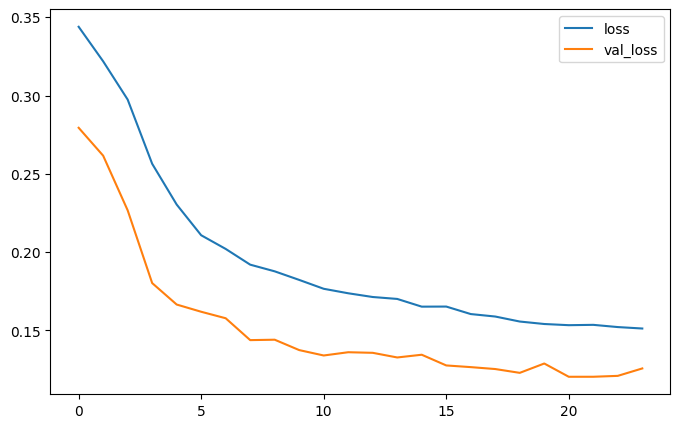

In [27]:
# Plot the training curves
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

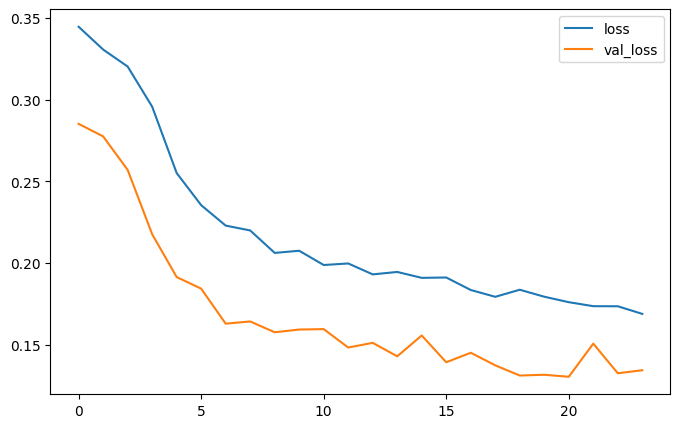

# Look at the results

## Take one sample and visualize the predicted trajectories

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


<Axes: >

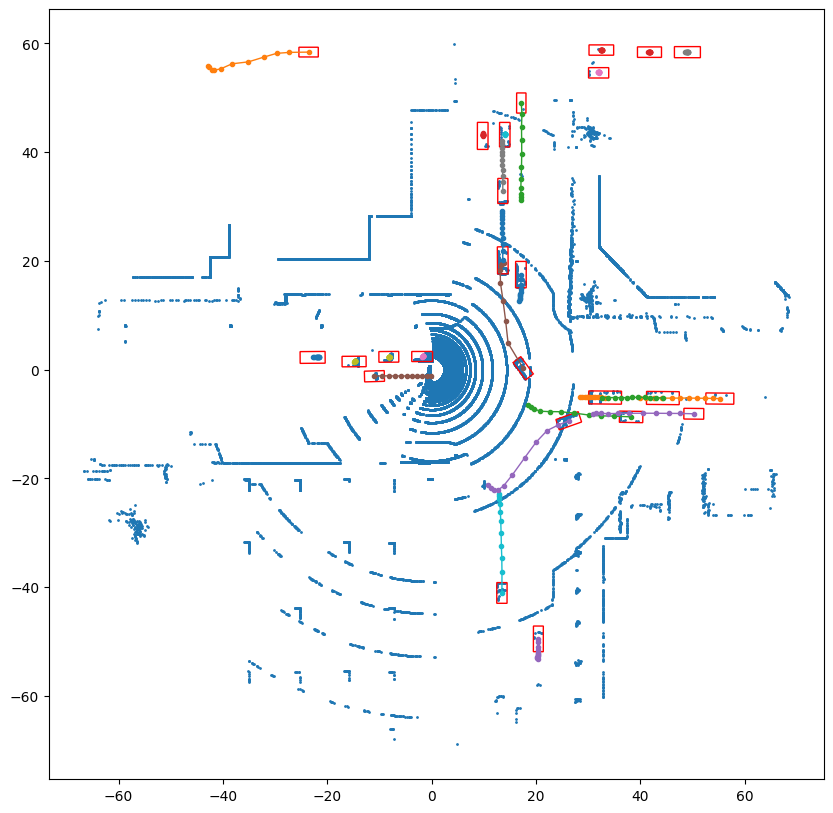

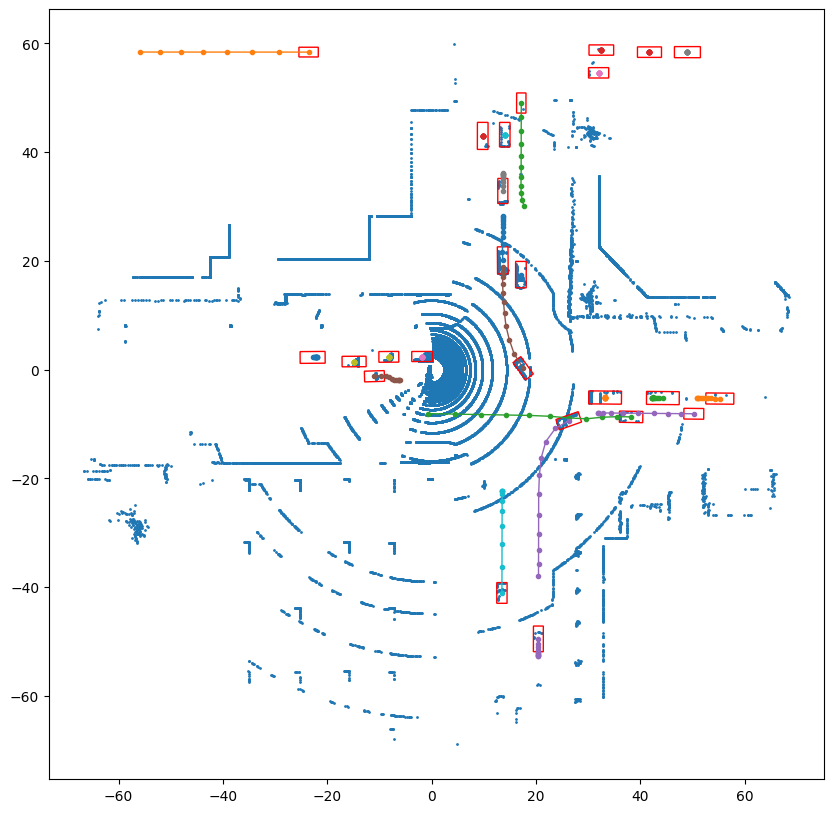

In [40]:
boxes, positions, mask, key_frame_points, keyframe_index = dataset_val.fetch_single(10)

############

# STUDENT: compute yaw for frames used as input (0..keyframe_index)
vec = boxes[:, :keyframe_index+1, 1, :2] - boxes[:, :keyframe_index+1, 0, :2]
yaw = np.arctan2(vec[:, :, 1], vec[:, :, 0])

# STUDENT: input now includes yaw -> (x, y, yaw, mask)
input = np.concatenate((positions[:, :keyframe_index+1],yaw[:, :, None],mask[:, :keyframe_index+1, None]),axis=-1)

##########################


pred = model.predict(input[None])

# As the output of this model is a relative offsets, not absolute coordinates, we need to add the input to get absolute values
pred = pred + input[None, :, -1:, :2]
pred = np.concatenate( (input[None, :, -1:, :2], pred), axis=2) # Also include the current frame.
_, n_agent, t, _ = pred.shape

# vis the prediction
vis_tracks(key_frame_points, boxes[:, keyframe_index], pred[0], maskes=np.full( (n_agent, t), True))
# vis the ground truth
vis_tracks(key_frame_points, boxes[:, keyframe_index], positions[:, keyframe_index:], mask[:, keyframe_index:])

### Prediction with Out Yaw as input

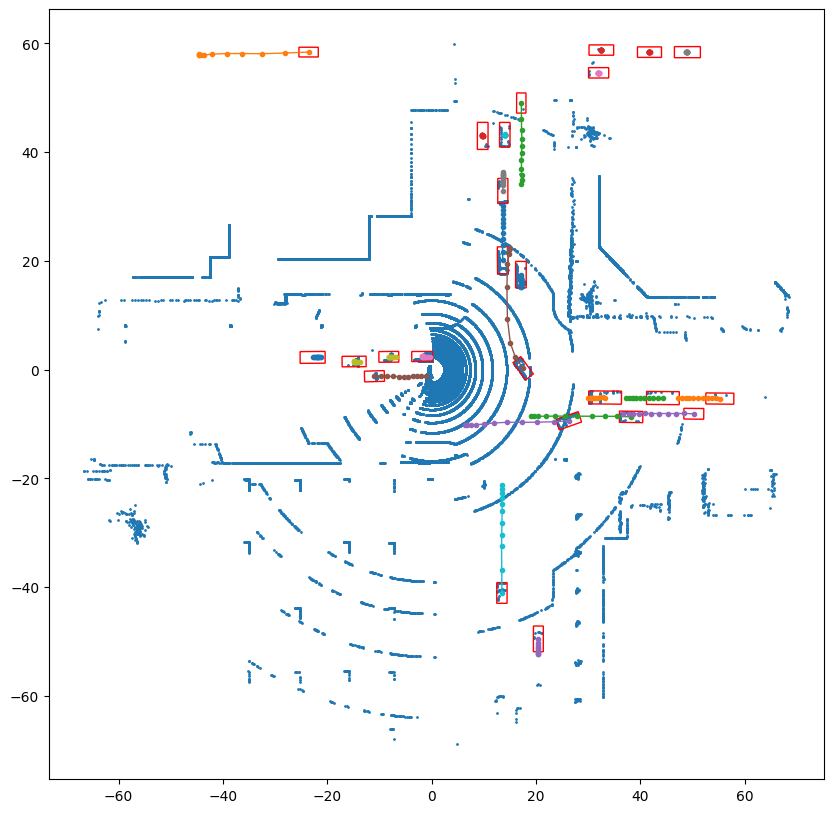

STUDENT Question:
* Interpret these output plots, does it seems like the model is doing its jobb?
* If it is hard to interpret can we illustrate the models performance in another way?

YOUR Answer:

It is somewhat difficult to interpret and directly compare the predicted trajectories with the ground truth for the same scene from the output plots alone. Overall, the model appears to perform reasonable well, capturing general motion trends and directions. However, for sharper turns near the intersections and for longer prediction horizons, the predictions tend to deviate more from the true trajectories, indicating reduced accurancy in more complex situations.

Therefore, this type of qualitative visualization is not sufficient to reliably assess model performence, for example during hyperparameter tuning or when modifying the model architecture to improve accuracy. Instead, the models performance should also be evaluated using quantitative metrics. A good choice is Average Displacement Error, which measures the average Eaclidean distance between the predicted trajectory and the corresponding ground-truth points over the prediction horizon. This provides an objective way to compare diffrent model versions and track improvments. 

# Evaluation

We use the Average Displacement Error as the metric to evaluate our model.

It measures the average Euclidean distance between the predicted trajectory points and the corresponding ground truth points

In [20]:
def evaluate_model(model, dataset):
    displacement_acc = 0
    n_eval_samples = 0

    # Iterate over batches
    for batch_idx in range(len(dataset)):
        # Get batch. targets has shape (Batch, Agents, Time, 3)
        # The 3 channels are [x, y, mask]
        inputs, targets = dataset[batch_idx]

        # Extract Ground Truth and Future Masks
        # Targets from dataset are relative, so we separate position from mask
        gt_relative = targets[:, :, :, :2]           # Shape: (B, A, 10, 2)
        gt_mask = targets[:, :, :, 2].astype(bool)   # Shape: (B, A, 10) - The FUTURE mask

        # Predict
        preds_relative = model.predict(inputs, verbose=0)

        # Convert to Absolute Coordinates
        # We add the last known position to both to make them comparable in absolute space
        last_known_pos = inputs[:, :, -1:, :2]
        preds_abs = preds_relative + last_known_pos
        gt_abs = gt_relative + last_known_pos

        # Calculate Displacement
        diff = preds_abs - gt_abs
        dist = np.linalg.norm(diff, axis=-1) # Shape: (B, A, 10)

        # Only sum errors where the agent actually exists in the ground truth
        valid_dist = dist[gt_mask]

        displacement_acc += np.sum(valid_dist)
        n_eval_samples += valid_dist.size

    return displacement_acc / n_eval_samples

In [29]:
print(f"Average Displacement Error: {evaluate_model(model, dataset_val):.3f}")

Average Displacement Error: 1.054


Base line Average Displacement Error: 1.031  /Rickard Sörlin

# Now then...
While the provided code offers a basic motion prediction model, it might not achieve optimal performance on this specific dataset.

Thus there is clear room for improvement.

### Exploration and Students Questions.
This lab challenges you to design and test your own model!

Considering the defined performance metric (Average Displacement Error), your objective is to explore and potentially outperform the baseline model on the given motion data.

Feel free to experiment with various approaches:

1. **Hyperparameter tuning and model architecture improvements**: Refine the existing model's hyperparameters or modify its architecture for better results.
2. **Traditional methods**: Explore techniques like Kalman filters, known for their motion prediction capabilities.
3. **Deep learning models**: Experiment with architectures like Graph Neural Networks, Convolutional Neural Networks (CNNs), or Recurrent Neural Networks (RNNs) that have proven successful in motion prediction tasks.

**Participation and documentation are key! Even if your model doesn't surpass the baseline, documenting your thought process is crucial.** This includes:

1. **Motivation:** Explain the rationale behind your chosen approach.
2. **Methodology:** Detail the steps you took to implement your model.
3. **Performance:** Report the model's Average Displacement Error on the dataset; the eraining time; and the number of parameters in the model. As well as other performance parameters that can be relevant.
4. **Comparative Analysis:** Do a comparative analysis beetween your model(s) and the provided model, what benefits and drawbacks exist between the studied models?




### My choice fall on hyperparameter tuning and model architecture improvments on existing model and use Hyperparameter insperation from the report: "Latent Variable Sequential Set Transformer for Joint Multi-Agent Motion Prediction"

![Skärmavbild 2025-12-25 kl. 17.49.22.png](<attachment:Skärmavbild 2025-12-25 kl. 17.49.22.png>)
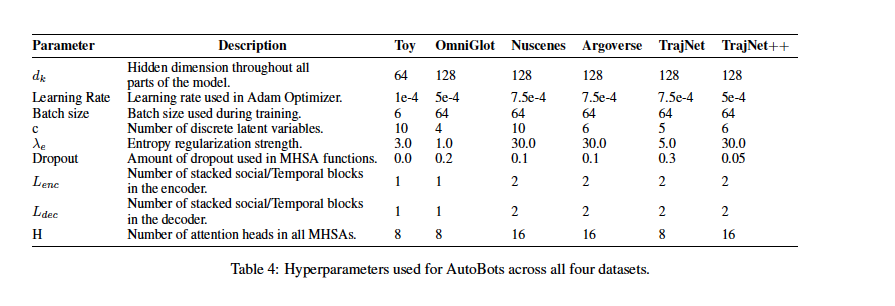

In [ ]:
import random, time
import pandas as pd
dims = [32, 64, 128] # default 64
heads = [4, 8] # default 4
lrs = [1e-3, 5e-4, 7.5e-4] # default 1e-3
num_epochs = 15 # default 25

best_ADE = float('inf')
best_params = None

SEED = 20251225
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

results = []

for intermediate_dim in dims:
    for num_heads in heads:
        for lr in lrs:
            es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
            model = MotionPredictor(pred_step, input_shape=input_shape, intermediate_dim=intermediate_dim, num_heads=num_heads)
            model.compile(loss=MotionLoss(), optimizer=keras.optimizers.Adam(learning_rate=lr))
            start = time.perf_counter()
            
            history = model.fit(dataset_train, epochs=num_epochs, callbacks = [es], validation_data=dataset_val, verbose=0)
            end = time.perf_counter()
            train_time = end - start
            best_val = float(np.min(history.history["val_loss"]))
            ADE = evaluate_model(model, dataset_val)
            n_params = int(model.count_params())
            
            print(f"ADE={ADE:.4f}, best_val_loss={best_val:.4f}, time={train_time:.1f}s, params={n_params:,}, dim={intermediate_dim}, heads={num_heads}, lr={lr}")
            results.append((ADE, best_val, train_time, n_params, intermediate_dim, num_heads, lr))
          
            if ADE < best_ADE:
                best_ADE = ADE
                best_params = (intermediate_dim, num_heads, lr)

print("Best ADE:", best_ADE, "params:", best_params)


results_df = pd.DataFrame(results, columns=["ADE", "best_val_loss", "train_time_s", "n_params", "intermediate_dim", "num_heads", "learning_rate"])
results_df = results_df.sort_values(by="ADE")

print(results_df)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

### My lab results from Hyperparameter Tuning and Architecture change:

Default Base line:
ADE=1.1547, best_val_loss=0.1427, time=192.8s, params=211,010, dim=64, heads=4, lr=0.001
# -------------------------------------------------------------------------------------- #

My best models:     
#### ADE=1.0409, best_val_loss=0.1285, time=194.3s, params=211,010, dim=64, heads=4, lr=0.0005
#### ADE=1.0446, best_val_loss=0.1332, time=207.2s, params=211,010, dim=64, heads=8, lr=0.001
#### ADE=1.0494, best_val_loss=0.1263, time=213.3s, params=831,618, dim=128, heads=4, lr=0.0005



* ADE=1.1171, best_val_loss=0.1382, time=193.6s, params=54,306, dim=32, heads=4, lr=0.001
* ADE=1.1651, best_val_loss=0.1401, time=194.5s, params=54,306, dim=32, heads=4, lr=0.0005
* ADE=1.2958, best_val_loss=0.1523, time=142.5s, params=54,306, dim=32, heads=4, lr=0.00075
* ADE=1.1907, best_val_loss=0.1409, time=200.5s, params=54,306, dim=32, heads=8, lr=0.001
* ADE=1.2357, best_val_loss=0.1461, time=201.7s, params=54,306, dim=32, heads=8, lr=0.0005
* ADE=1.1864, best_val_loss=0.1476, time=201.2s, params=54,306, dim=32, heads=8, lr=0.00075
* ADE=1.1547, best_val_loss=0.1427, time=192.8s, params=211,010, dim=64, heads=4, lr=0.001
* ADE=1.0409, best_val_loss=0.1285, time=194.3s, params=211,010, dim=64, heads=4, lr=0.0005
* ADE=1.2330, best_val_loss=0.1408, time=180.0s, params=211,010, dim=64, heads=4, lr=0.00075
* ADE=1.0446, best_val_loss=0.1332, time=207.2s, params=211,010, dim=64, heads=8, lr=0.001
* ADE=1.0867, best_val_loss=0.1267, time=209.3s, params=211,010, dim=64, heads=8, lr=0.0005
* ADE=1.0571, best_val_loss=0.1299, time=208.0s, params=211,010, dim=64, heads=8, lr=0.00075
* ADE=2.2625, best_val_loss=0.2809, time=85.2s, params=831,618, dim=128, heads=4, lr=0.001
* ADE=1.0494, best_val_loss=0.1263, time=213.3s, params=831,618, dim=128, heads=4, lr=0.0005
* ADE=1.6558, best_val_loss=0.2036, time=128.1s, params=831,618, dim=128, heads=4, lr=0.00075
* ADE=2.2448, best_val_loss=0.2843, time=77.2s, params=831,618, dim=128, heads=8, lr=0.001
* ADE=1.1072, best_val_loss=0.1268, time=231.7s, params=831,618, dim=128, heads=8, lr=0.0005
* ADE=1.3570, best_val_loss=0.1527, time=138.5s, params=831,618, dim=128, heads=8, lr=0.00075
* Best ADE: 1.0408703050641384 params: (64, 4, 0.0005)

In [ ]:
results_df = pd.DataFrame(results, columns=["ADE", "best_val_loss", "train_time_s", "n_params", "intermediate_dim", "num_heads", "learning_rate"])
results_df = results_df.sort_values(by="ADE")

results_df.head()
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

dims = [64, 128] # default 64
heads = [4, 8] # default 4
lrs = [1e-3, 5e-4] # default 1e-3
num_epochs = 30 # default 25

results_df

,ADE,best_val_loss,train_time_s,n_params,intermediate_dim,num_heads,learning_rate
7,1.040870,0.128472,194.312393,211010,64,4,0.00050
9,1.044580,0.133211,207.229969,211010,64,8,0.00100
13,1.049351,0.126294,213.259737,831618,128,4,0.00050
11,1.057128,0.129933,208.029624,211010,64,8,0.00075
10,1.086693,0.126686,209.334335,211010,64,8,0.00050
16,1.107180,0.126839,231.714430,831618,128,8,0.00050
0,1.117090,0.138248,193.595395,54306,32,4,0.00100
6,1.154696,0.142674,192.846157,211010,64,4,0.00100
1,1.165103,0.140130,194.505109,54306,32,4,0.00050
5,1.186426,0.147564,201.216315,54306,32,8,0.00075


YOUR Analysis:


1. **Motivation:** 

I chose to focus on the hyperparameter tuning and minor architecture adjustments of the provided Transformer based model, using the paper 
"Latent Variable Sequential Set Transformer for Joint Multi-Agent Motion Prediction" as insperation for reasonable hyperparameter ranges. The reason for this approach is that the baseline model is already designed around Transformer architecture, which is well suited for motion prediction due to its ability to model dependecies using attention and to process sequences efficiently in parallel.

Compared to an RNN based approach, Transformer can model long-range temporal dependecies using attention and they process all time steps in parallel during training rather then strictly sequentially. This often makes optimization easier and allows more efficient GPU utilisation, alhough Transformer can more computationally expensive than recurrent models at inference and training.

The Transfromer architecture in this lab explicitly combines temporal encoding with positional encoding to represent each agent trajectory over time, togheter with social attention layers that models interactions between agents in the scene. This makes the Transformer a natural choice for multi-agent motion prediction, were both temporal dynamics and agent-to-agent relationships matter over other models.

Since dataset in this lab is relatively small, we keep the model capacity moderate limited hidden dimension and number of attention heads and use early stopping to reduce overfitting. 
This balance prediction performence ADE with model complexity and training/ingerence cost.

Given the limited scope and time of the lab, tuning existing Transformer architecture was a practical way to aim for improved ADE while staying close to the design choices motivated by the reference paper.


2. **Methodology:** 

To systematic evaluate diffrent architectural choices (hidden dimension and number of attentions heads) and training hyperparameters (learning rate) a manual grid search inspired by the range reported in "Latent Variable Sequential Set Transformer for Joint Multi-Agent Motion Prediction". 
A simply nested-loops grid search evaluated all combinations. To make the comparison reproducible, a fixed random seed was set before training. Early stopping on validation loss was also used to reduce overfitting and avoid unnecessary training. Each configuration was evaluated using Average Displacement Error on the full validation set.


3. **Performance:** 

The diffrent model architectures and hyperparameters used is shown in bellow screen print where its sorted on ADE, the models performance was evaluated on the full validation dataset using ADE 
were lower number is bether. The default base model results us shown within the red rectangel.
All models were trained using same value for maximum number epochs set to 15, and early stopping based validation loss applied, meaning the effective number of epochs could vary between configuration.

* Base line model:  ADE = 1.1547 , validation loss = 0.1427, training time = 192.8 s ,parameters 211 010, intermediate_dim = 64, num_heads = 4, learning rate = 1e-3
* Best tuned model: ADE = 1.0409 , validation loss = 0.1285, training time = 194.3 s ,parameters 211 010, intermediate_dim = 64, num_heads = 4, learning rate = 5e-4


![Skärmavbild 2025-12-26 kl. 09.52.14.png](<attachment:Skärmavbild 2025-12-26 kl. 09.52.14.png>)
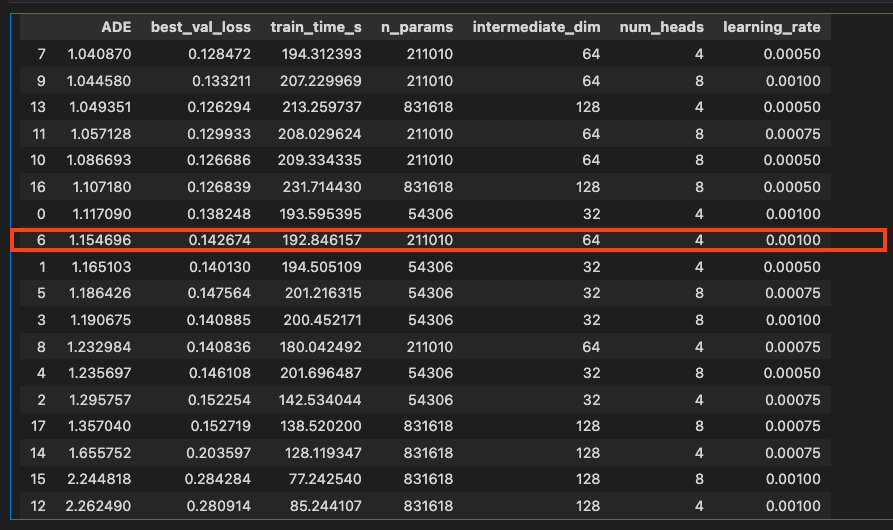

4. **Comparative Analysis:** 

Although all models are trained and evaluated on same imbalanced dataset, which ensures a fair comparison, the strong dominance of stationary agents means that ADE is influenced mainly by easier cases. Therefore, improvments in ADE may not fully reflect performance on moving agents. The baseline configuration is highlighted in red in the results table.

The comparative results show that increased model complexity does not necessarity lead to improved motion prediction performance. Configuration with larger hidden dimensions and more attention heads did not consitenly archive lower ADE then smaller models, despite higher computational cost in serveral cases, models with moderate capacity archived equal or better ADE, suggesting that the dataset size limits the benefit of increased model capacity. 

The best performing configuration archived a clear improvments over the baseline without increasing the number of parameters, indicating the improved optimisation of learning rate can be more effective than increasing model size. Larger models tended to increase training cost and may also increase inference latency, while not providing propotional gains in ADE.

Overall, the results highlights a trade off between prediction accuracy and model complexity. For this dataset, a moderately sized Transformer provides the best balance between ADE performance and computational efficiency.

# BONUS TASK

At the moment we are extracting only the x and y position from the data, but one can suspect that the yaw angle also could help these prediction.

Please do an experiment where you modify the code to extract the yaw angle  from the data and give that as part of the input (together with the three parameters already there) to the model. Evaluate the new model's performance and its key parameters, as well as doing a comparative analysis between all models you have in this Lab.

You need to be very careful to document all your changes to the code. Preferable with a "STUDENT" in a comment at the place of modifications.

Easiest might be to make a copy of your file at this point and modify the second copy with the changes in this bonus part, and then hand in two colab files.

In [ ]:
x, y = dataset_train[0]
print("x last dim:", x.shape[-1], "y last dim:", y.shape[-1])

x last dim: 4 y last dim: 3


In [ ]:
import random, time
import pandas as pd
dims = [32, 64, 128] # default 64
heads = [4, 8] # default 4
lrs = [1e-3, 5e-4, 7.5e-4] # default 1e-3
num_epochs = 15 # default 25

best_ADE = float('inf')
best_params = None

SEED = 20251225
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

results = []

for intermediate_dim in dims:
    for num_heads in heads:
        for lr in lrs:
            es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
            model = MotionPredictor(pred_step, input_shape=input_shape, intermediate_dim=intermediate_dim, num_heads=num_heads)
            model.compile(loss=MotionLoss(), optimizer=keras.optimizers.Adam(learning_rate=lr))
            start = time.perf_counter()
            
            history = model.fit(dataset_train, epochs=num_epochs, callbacks = [es], validation_data=dataset_val, verbose=0)
            end = time.perf_counter()
            train_time = end - start
            best_val = float(np.min(history.history["val_loss"]))
            ADE = evaluate_model(model, dataset_val)
            n_params = int(model.count_params())
            
            print(f"ADE={ADE:.4f}, best_val_loss={best_val:.4f}, time={train_time:.1f}s, params={n_params:,}, dim={intermediate_dim}, heads={num_heads}, lr={lr}")
            results.append((ADE, best_val, train_time, n_params, intermediate_dim, num_heads, lr))
          
            if ADE < best_ADE:
                best_ADE = ADE
                best_params = (intermediate_dim, num_heads, lr)

print("Best ADE:", best_ADE, "params:", best_params)


results_df = pd.DataFrame(results, columns=["ADE", "best_val_loss", "train_time_s", "n_params", "intermediate_dim", "num_heads", "learning_rate"])
results_df = results_df.sort_values(by="ADE")

print(results_df)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

ADE=1.2590, best_val_loss=0.1498, time=202.6s, params=54,338, dim=32, heads=4, lr=0.001
ADE=1.1352, best_val_loss=0.1413, time=208.2s, params=54,338, dim=32, heads=4, lr=0.0005
ADE=1.1227, best_val_loss=0.1336, time=208.1s, params=54,338, dim=32, heads=4, lr=0.00075
ADE=1.1523, best_val_loss=0.1365, time=213.2s, params=54,338, dim=32, heads=8, lr=0.001
ADE=1.2341, best_val_loss=0.1457, time=211.6s, params=54,338, dim=32, heads=8, lr=0.0005
ADE=1.1371, best_val_loss=0.1368, time=212.9s, params=54,338, dim=32, heads=8, lr=0.00075
ADE=1.1640, best_val_loss=0.1398, time=206.8s, params=211,074, dim=64, heads=4, lr=0.001
ADE=1.1098, best_val_loss=0.1336, time=204.9s, params=211,074, dim=64, heads=4, lr=0.0005
ADE=1.1711, best_val_loss=0.1421, time=207.5s, params=211,074, dim=64, heads=4, lr=0.00075
ADE=1.0691, best_val_loss=0.1304, time=218.0s, params=211,074, dim=64, heads=8, lr=0.001
ADE=1.1539, best_val_loss=0.1324, time=219.0s, params=211,074, dim=64, heads=8, lr=0.0005
ADE=1.0806, best_

In [ ]:
results_df = pd.DataFrame(results, columns=["ADE", "best_val_loss", "train_time_s", "n_params", "intermediate_dim", "num_heads", "learning_rate"])
results_df = results_df.sort_values(by="ADE")

results_df.head()
results_df.to_csv("hyperparameter_tuning_results_Bonus_Task.csv", index=False)

results_df

,ADE,best_val_loss,train_time_s,n_params,intermediate_dim,num_heads,learning_rate
9,1.069078,0.130387,217.991644,211074,64,8,0.00100
11,1.080586,0.131363,219.117387,211074,64,8,0.00075
7,1.109814,0.133583,204.934254,211074,64,4,0.00050
2,1.122704,0.133629,208.082511,54338,32,4,0.00075
1,1.135219,0.141332,208.196568,54338,32,4,0.00050
5,1.137057,0.136803,212.927619,54338,32,8,0.00075
3,1.152270,0.136513,213.177891,54338,32,8,0.00100
10,1.153890,0.132447,218.961127,211074,64,8,0.00050
6,1.163991,0.139814,206.769577,211074,64,4,0.00100
8,1.171059,0.142095,207.468987,211074,64,4,0.00075


![Skärmavbild 2025-12-26 kl. 16.26.14.png](<attachment:Skärmavbild 2025-12-26 kl. 16.26.14.png>)
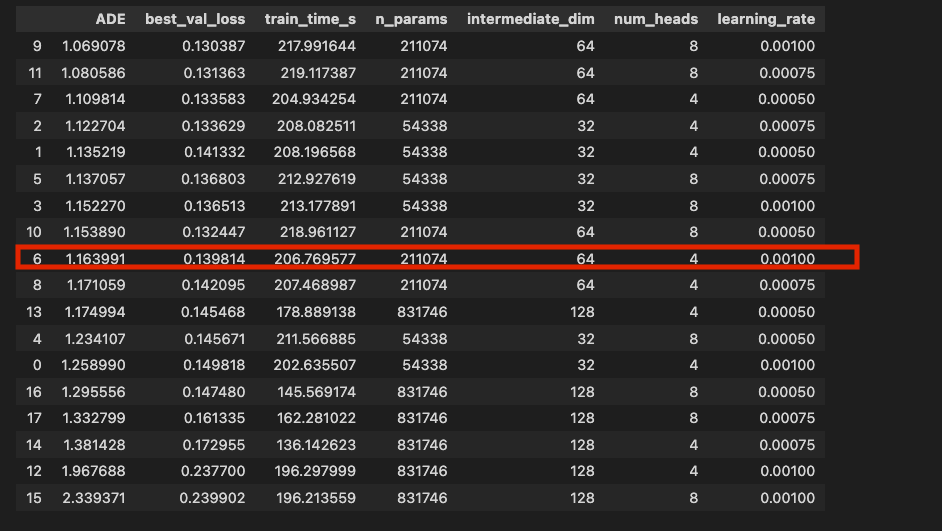


### Motion Prediction with OUT Yaw added to input and architecture

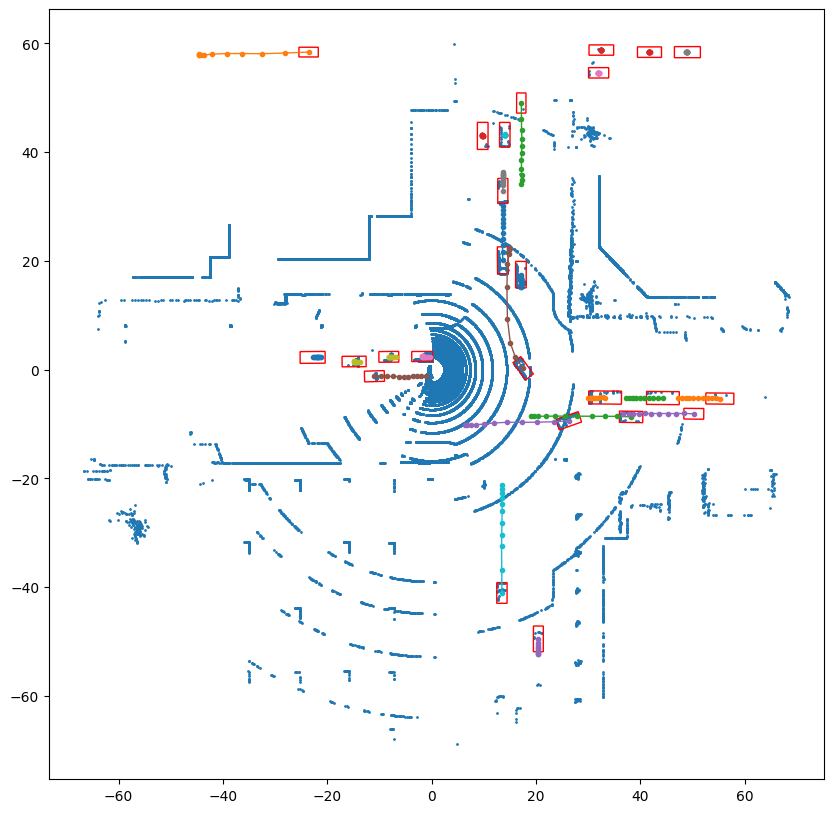


### Motion Prediction with yaw added to input and architecture
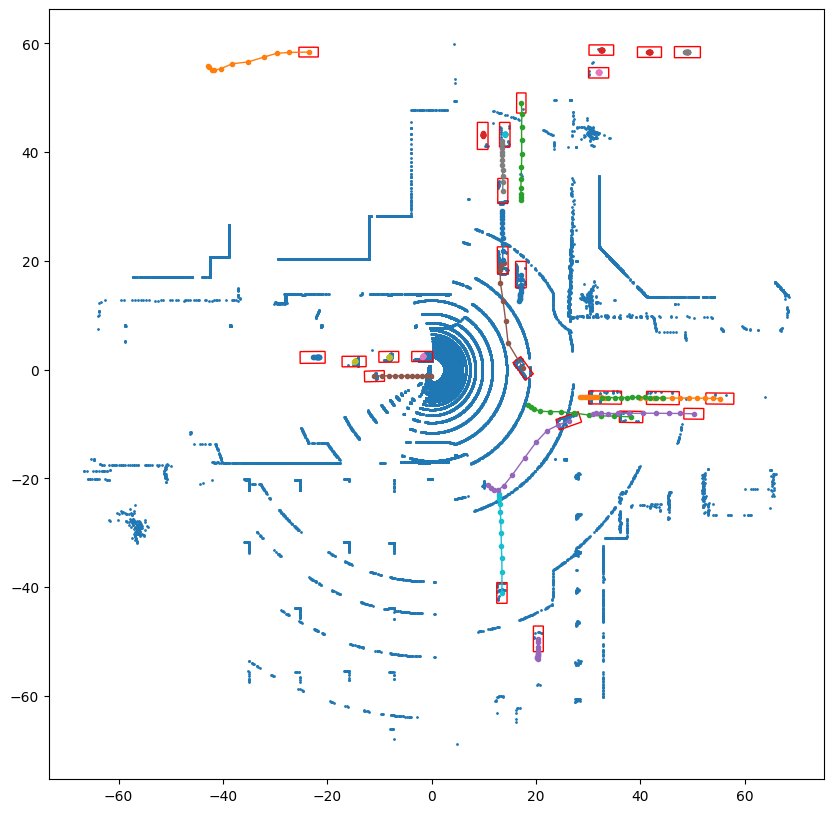

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


<Axes: >

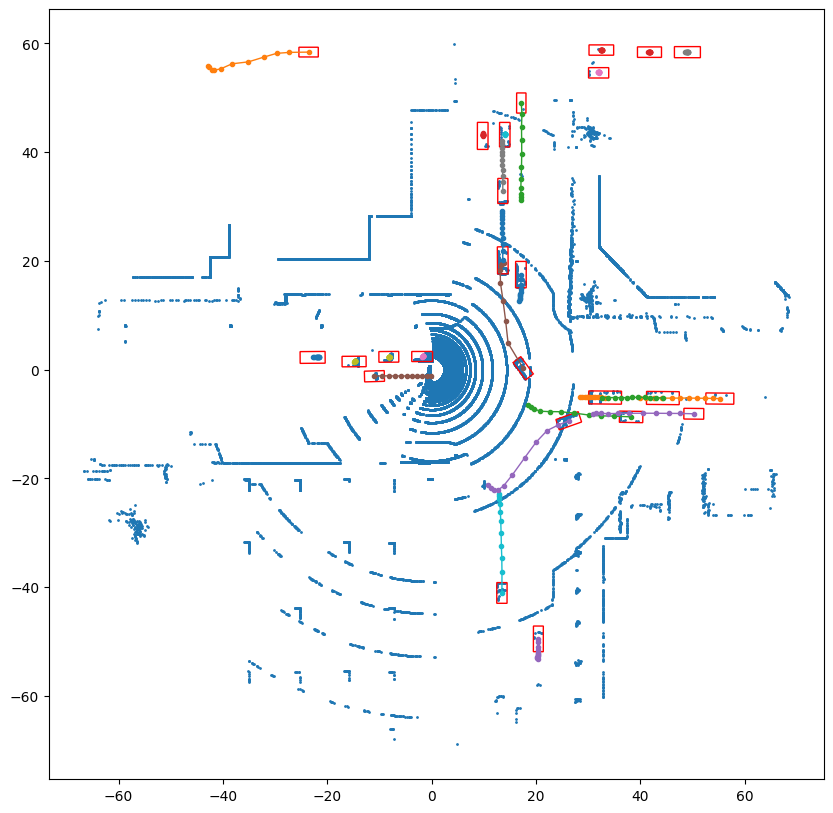

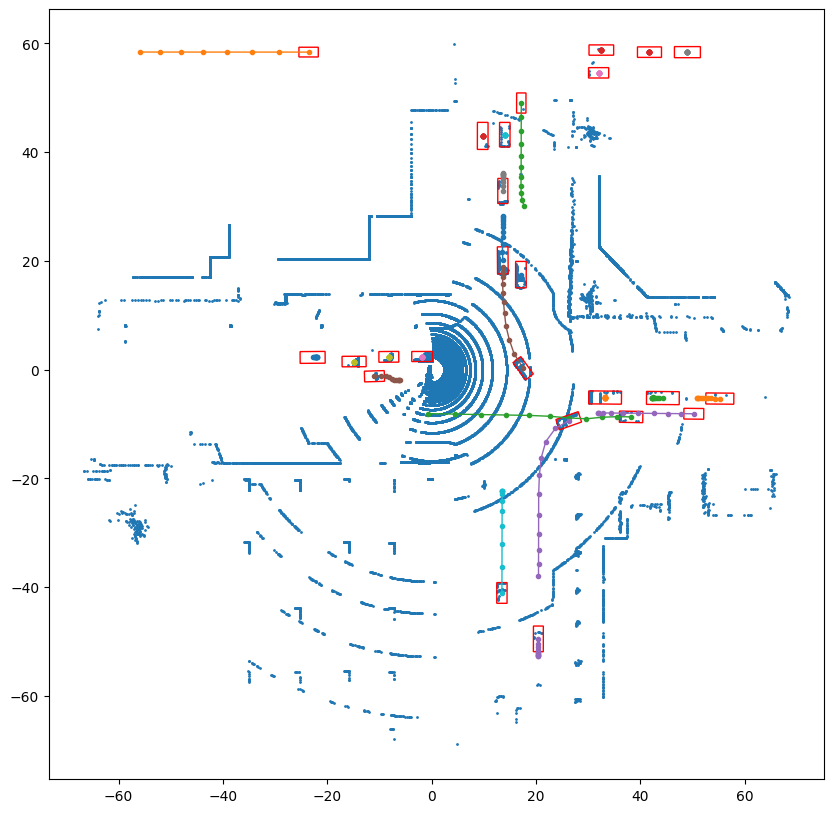

In [39]:
boxes, positions, mask, key_frame_points, keyframe_index = dataset_val.fetch_single(10)

############

# STUDENT: compute yaw for frames used as input (0..keyframe_index)
vec = boxes[:, :keyframe_index+1, 1, :2] - boxes[:, :keyframe_index+1, 0, :2]
yaw = np.arctan2(vec[:, :, 1], vec[:, :, 0])

# STUDENT: input now includes yaw -> (x, y, yaw, mask)
input = np.concatenate((positions[:, :keyframe_index+1],yaw[:, :, None],mask[:, :keyframe_index+1, None]),axis=-1)

##########################


pred = model.predict(input[None])

# As the output of this model is a relative offsets, not absolute coordinates, we need to add the input to get absolute values
pred = pred + input[None, :, -1:, :2]
pred = np.concatenate( (input[None, :, -1:, :2], pred), axis=2) # Also include the current frame.
_, n_agent, t, _ = pred.shape

# vis the prediction
vis_tracks(key_frame_points, boxes[:, keyframe_index], pred[0], maskes=np.full( (n_agent, t), True))
# vis the ground truth
vis_tracks(key_frame_points, boxes[:, keyframe_index], positions[:, keyframe_index:], mask[:, keyframe_index:])